In [10]:
import os

nb_name = "nb20230512_175700_eval_motion_correction_win.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230512_175700_eval_motion_correction_win.ipynb to python
[NbConvertApp] Writing 8251 bytes to d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230512_175700_eval_motion_correction_win.py


In [2]:

dir_by_sessions = r"\\ettin\Magill_lab\Julien\Data\head-fixed\by_sessions"


def join_task_session(taskname, sessionnames: list):
    return [os.path.join(dir_by_sessions, taskname, ssn) for ssn in sessionnames]

task1 = join_task_session('reaching_go_spout_bar_nov22', [
    'kms058-2023-03-24-151254'])

debug_folders = task1


In [3]:
import pandas as pd
from trialexp.process.pycontrol.utils import export_session
from snakehelper.SnakeIOHelper import getSnake
# from workflow.scripts import settings
from re import match
from pathlib import Path
from trialexp.process.pyphotometry.utils import *


class sinput_class():
    def __init__(self):
        self.photometry_folder = None
        self.pycontrol_dataframe = None
        self.pycontrol_folder = None


def load_and_prep_photom(debug_folder):
    # (sinput, soutput) = getSnake(locals(), 'workflow/pycontrol.smk',
    #                             os.path.join(debug_folder, '/processed/spike2.smrx'),
    #                             'export_spike2')
    sinput = sinput_class()
    sinput.photometry_folder = os.path.join(debug_folder, 'pyphotometry')
    sinput.pycontrol_dataframe = os.path.join(
        debug_folder, 'processed', 'df_pycontrol.pkl')
    sinput.pycontrol_folder = os.path.join(debug_folder, 'pycontrol')

    # %% Photometry dict

    # fn = glob(sinput.photometry_folder+'\*.ppd')[0]
    fn = list(Path(sinput.photometry_folder).glob('*.ppd'))
    if fn == []:
        data_photometry = None
    else:
        fn = fn[0]
        data_photometry = import_ppd(fn)

        data_photometry = denoise_filter(data_photometry) #TODO
        data_photometry = motion_correction(data_photometry) #TODO
        data_photometry = compute_df_over_f(
            data_photometry, low_pass_cutoff=0.001)

    # no down-sampling here

    # %% Load data
    df_pycontrol = pd.read_pickle(sinput.pycontrol_dataframe)

    pycontrol_time = df_pycontrol[df_pycontrol.name == 'rsync'].time

    # assuming just one txt file
    pycontrol_txt = list(Path(sinput.pycontrol_folder).glob('*.txt'))

    with open(pycontrol_txt[0], 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]

    count = 0
    print_lines = []
    while count < len(all_lines):
        # all_lines[count][0] == 'P'
        if bool(match('P\s\d+\s', all_lines[count])):
            print_lines.append(all_lines[count][2:])
            count += 1
            while (count < len(all_lines)) and not (bool(match('[PVD]\s\d+\s', all_lines[count]))):
                print_lines[-1] = print_lines[-1] + \
                    "\n" + all_lines[count]
                count += 1
        else:
            count += 1

    v_lines = [line[2:] for line in all_lines if line[0] == 'V']

    # %%
    if fn == []:
        photometry_times_pyc = None
    else:
        photometry_aligner = Rsync_aligner(
            pycontrol_time, data_photometry['pulse_times_2'])
        photometry_times_pyc = photometry_aligner.B_to_A(
            data_photometry['time'])

    # remove all state change event
    df_pycontrol = df_pycontrol.dropna(subset='name')
    df2plot = df_pycontrol[df_pycontrol.type == 'event']
    # state is handled separately with export_state, whereas parameters are handled vchange_to_text

    keys = df2plot.name.unique()

    photometry_keys = ['analog_1', 'analog_2',  'analog_1_filt', 'analog_2_filt',
                       'analog_1_est_motion', 'analog_1_corrected', 'analog_1_baseline_fluo',
                       'analog_1_df_over_f']

    return df_pycontrol, pycontrol_time, data_photometry, photometry_times_pyc, photometry_keys

# export_session(df_pycontrol, keys,
#     data_photometry = data_photometry,
#     photometry_times_pyc = photometry_times_pyc,
#     photometry_keys = photometry_keys,
#     print_lines = print_lines,
#     v_lines = v_lines,
#     smrx_filename=soutput.spike2_file)


In [4]:
data_list = []

for d in debug_folders:
    data_dict = dict(df_pycontrol=None, pycontrol_time=None, data_photometry=None,
                     photometry_times_pyc=None, photometry_keys=None, debug_folder=None)
    data_dict['df_pycontrol'], data_dict['pycontrol_time'], data_dict['data_photometry'], \
        data_dict['photometry_times_pyc'], data_dict['photometry_keys'] = load_and_prep_photom(
            d)
    data_dict['debug_folder'] = d
    data_list.append(data_dict)
df_data = pd.DataFrame(data_list)

df_data['subject_ID'] = [r['subject_ID']
                         if r is not None else None for r in df_data['data_photometry']]
df_data['date_time'] = [r['date_time']
                        if r is not None else None for r in df_data['data_photometry']]


# Break into windows

run linregress for each window

they join the windows with overlap somehow to recover data


In [5]:

sampling_rate = df_data.loc[0,'data_photometry']['sampling_rate']

win_size_s = 30

n_win_size = int(win_size_s * sampling_rate)
n_overlap = int(n_win_size/2)  # 50% overlap



analog_1 = df_data.loc[0,'data_photometry']['analog_1']
analog_2 = df_data.loc[0,'data_photometry']['analog_2']

In [6]:

def overlapping_chunks(data1, data2, n_win_size: int, n_overlap: int):
    # if not isinstance(chunk_size, int) or not chunk_size.is_integer():
    #     raise ValueError("chunk_size must be an integer")
        
    x = n_win_size/n_overlap

    if isinstance(x, float) and not x.is_integer():
        raise ValueError("1/overlap_ratio must be an integer")
    elif isinstance(x, int):
        pass

    step_size = n_win_size - int(n_win_size) // int(x)
    # for i in range(0, len(data1) - n_win_size + 1, step_size): #TODO this will skip the last iteration
    #     yield i, data1[i:i + n_win_size], data2[i:i + n_win_size]
    for i in range(0, len(data1), step_size):
        if i + n_win_size <= len(data1):  # If a full-sized chunk can be taken
            yield i, data1[i:i + n_win_size], data2[i:i + n_win_size]
        else:  # If only a truncated chunk can be taken
            yield i, data1[i:], data2[i:]


start_index_chunks = []
analog_1_est_motion_chunks = []
p_vals = []
r_vals = []
for start_ind, chunk1, chunk2 in overlapping_chunks(analog_1, analog_2, 
                                              n_win_size, n_overlap):
    slope, intercept, r_value, p_value, std_err = linregress(chunk2, chunk1)

    start_index_chunks.append(start_ind)

    analog_1_est_motion_chunks.append(slope * chunk2 + intercept)
    p_vals.append(p_value)
    r_vals.append(r_value)


The simplest idea is to compute the average of the two vectors for matching datapoints.

If the joints do not look continuous, then I can try averaging with a moving weight.

When vectors A and B are matching from k = 1 to n, and A is the latter half of window, while B is the former half of window,

$$

C = \sum_{k = 1}^{n} A_i \times \frac{n-k}{n} + B_i \times \frac{k}{n}   

$$

In [7]:
# reconstruct a vector

analog_1_est_motion_joined = np.zeros(np.size(analog_1))


In [8]:
step_size = n_win_size - int(n_win_size) // int(n_win_size/n_overlap)

for i in range(0, len(start_index_chunks)):
    ch = analog_1_est_motion_chunks[i]

    if i == 0:
        analog_1_est_motion_joined[0:step_size] = ch[0:step_size]

    elif i > 0 and i < len(start_index_chunks) -1:
        ch_prev = analog_1_est_motion_chunks[i-1]
        ind_this =  start_index_chunks[i]
        
        # average two chunks
        analog_1_est_motion_joined[ind_this:ind_this + step_size] \
            = (ch[0:step_size] + ch_prev[step_size-1:-1])/2

    elif i == len(start_index_chunks) -1 :
        ind_this =  start_index_chunks[i]

        # copy one chunk
        analog_1_est_motion_joined[ind_this:ind_this + step_size] = ch

    elif i == len(start_index_chunks):
        print('should not happen')


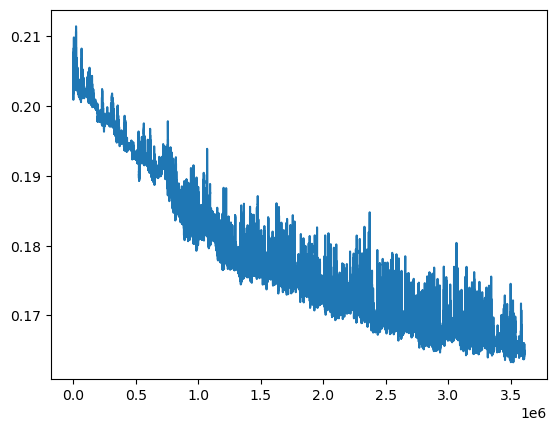

In [9]:
fig = plt.figure()

plt.plot(analog_1_est_motion_joined)
plt.show()
